In [1]:
# Imports
# !pip install torchinfo
import torch
import torch.nn as nn
import torch.utils.data as Data
from torchvision import datasets, transforms
from torchinfo import summary
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import time
import Trainer_v03b5 as TP

## Network structures

In [3]:
m1 = mymodel.ImageEncoder()
summary(m1, input_size=(1, 1, 128, 128))

Layer (type:depth-idx)                   Output Shape              Param #
ImageEncoder                             [1, 256]                  --
├─Sequential: 1-1                        [1, 16, 64, 64]           --
│    └─Conv2d: 2-1                       [1, 16, 128, 128]         160
│    └─LeakyReLU: 2-2                    [1, 16, 128, 128]         --
│    └─MaxPool2d: 2-3                    [1, 16, 64, 64]           --
├─Sequential: 1-2                        [1, 32, 32, 32]           --
│    └─Conv2d: 2-4                       [1, 32, 64, 64]           4,640
│    └─LeakyReLU: 2-5                    [1, 32, 64, 64]           --
│    └─MaxPool2d: 2-6                    [1, 32, 32, 32]           --
├─Sequential: 1-3                        [1, 64, 16, 16]           --
│    └─Conv2d: 2-7                       [1, 64, 32, 32]           18,496
│    └─LeakyReLU: 2-8                    [1, 64, 32, 32]           --
│    └─MaxPool2d: 2-9                    [1, 64, 16, 16]           --
├─Seque

In [4]:
m2 = mymodel.ImageDecoder()
summary(m2, input_size=(1, 256))

Layer (type:depth-idx)                   Output Shape              Param #
ImageDecoder                             [1, 1, 128, 128]          --
├─Sequential: 1-1                        [1, 256]                  --
│    └─Linear: 2-1                       [1, 4096]                 1,052,672
│    └─ReLU: 2-2                         [1, 4096]                 --
│    └─Linear: 2-3                       [1, 256]                  1,048,832
│    └─ReLU: 2-4                         [1, 256]                  --
├─Sequential: 1-2                        [1, 64, 32, 32]           --
│    └─ConvTranspose2d: 2-5              [1, 64, 32, 32]           1,088
│    └─LeakyReLU: 2-6                    [1, 64, 32, 32]           --
├─Sequential: 1-3                        [1, 32, 64, 64]           --
│    └─ConvTranspose2d: 2-7              [1, 32, 64, 64]           32,800
│    └─LeakyReLU: 2-8                    [1, 32, 64, 64]           --
├─Sequential: 1-4                        [1, 1, 128, 128]       

In [5]:
m3 = mymodel.CsiEncoder()
summary(m3, input_size=(2, 90, 100))

Layer (type:depth-idx)                   Output Shape              Param #
CsiEncoder                               [1, 256]                  353,374,464
├─Sequential: 1-1                        [1, 16, 30, 98]           --
│    └─Conv2d: 2-1                       [1, 16, 30, 98]           160
│    └─LeakyReLU: 2-2                    [1, 16, 30, 98]           --
├─Sequential: 1-2                        [1, 32, 14, 48]           --
│    └─Conv2d: 2-3                       [1, 32, 14, 48]           4,640
│    └─LeakyReLU: 2-4                    [1, 32, 14, 48]           --
├─Sequential: 1-3                        [1, 64, 12, 46]           --
│    └─Conv2d: 2-5                       [1, 64, 12, 46]           18,496
│    └─LeakyReLU: 2-6                    [1, 64, 12, 46]           --
├─Sequential: 1-4                        [1, 128, 10, 44]          --
│    └─Conv2d: 2-7                       [1, 128, 10, 44]          73,856
│    └─LeakyReLU: 2-8                    [1, 128, 10, 44]       

## Loader

In [2]:
datadir = '../Dataset/0307make06/'
print(os.listdir(datadir))

['csi.npy', 'img.npy']


In [3]:
transform = transforms.Compose([transforms.Resize([128,128]),
                                transforms.ToTensor(),
                      #          transforms.Normalize((0.5, ), (0.5, ))
])

# Specify x and y
mydata = TP.MyDataset(datadir + 'csi.npy',
                      datadir + 'img.npy',
                      (128, 128),
                      img='y')
print(mydata.data['x'].shape, mydata.data['y'].shape)

train_size = int(len(mydata) * 0.7)
valid_size = int(len(mydata) * 0.2)
test_size = int(len(mydata)) - train_size - valid_size
print(train_size, valid_size, test_size)

train_loader, valid_loader, test_loader = TP.split_loader(mydata, train_size, valid_size, test_size, 8)

loaded
(7638, 2, 90, 100) (7638, 1, 128, 128)
5346 1527 765
5346 1527 765


In [4]:
# Hyperparameters
t_args = TP.MyArgs(cuda=0, epochs=10, learning_rate=1e-4, criterion=nn.BCELoss(reduction="sum"))
s_args = TP.MyArgs(cuda=0, epochs=10, learning_rate=1e-4, criterion=nn.MSELoss())

In [5]:
# Model and Loss
imgencoder = TP.ImageEncoderM1(batchnorm=False, latent_dim=8).to(t_args.device)
imgdecoder = TP.ImageDecoderM1(batchnorm=False, latent_dim=8, active_func=nn.Sigmoid()).to(t_args.device)
csiencoder = TP.CsiEncoder(batchnorm=False, latent_dim=8).to(t_args.device)

trainer = TP.TrainerVTSM1(img_encoder=imgencoder, img_decoder=imgdecoder, csi_encoder=csiencoder,
                            teacher_args=t_args, student_args=s_args, 
                            train_loader=train_loader, valid_loader=valid_loader, test_loader=test_loader,
                            temperature=1, batch_size=64, kl_weight=1)

# Load from checkpoints
trainer.toal_epochs=0
imgencoder.load_state_dict(torch.load('../Models/ImgEn_Model_v02a1_ImgEn_Fc_0307_tep1200.pth'))
imgdecoder.load_state_dict(torch.load('../Models/ImgDe_Model_v02a1_ImgDe_FC_0307_tep1200.pth'))
csiencoder.load_state_dict(torch.load('../Models/CSIEn_Model_v02a1_CsiEn_Last_0307_tep1200_sep700.pth'))

In [14]:
# When changing learning rate
t_args = TP.MyArgs(cuda=0, epochs=1000, learning_rate=1e-5, criterion=nn.SmoothL1Loss())
s_args = TP.MyArgs(cuda=0, epochs=100, learning_rate=1e-7, criterion=nn.SmoothL1Loss())
trainer.args={'t':t_args, 's':s_args}

Teacher: epoch=9/10, 665/668 of train, recon_loss=-31897534.0, kl_loss=917.9317626953125578
Total training time: 286.4697551727295 sec
Teacher: 665/668 of test, loss=-4173714.55

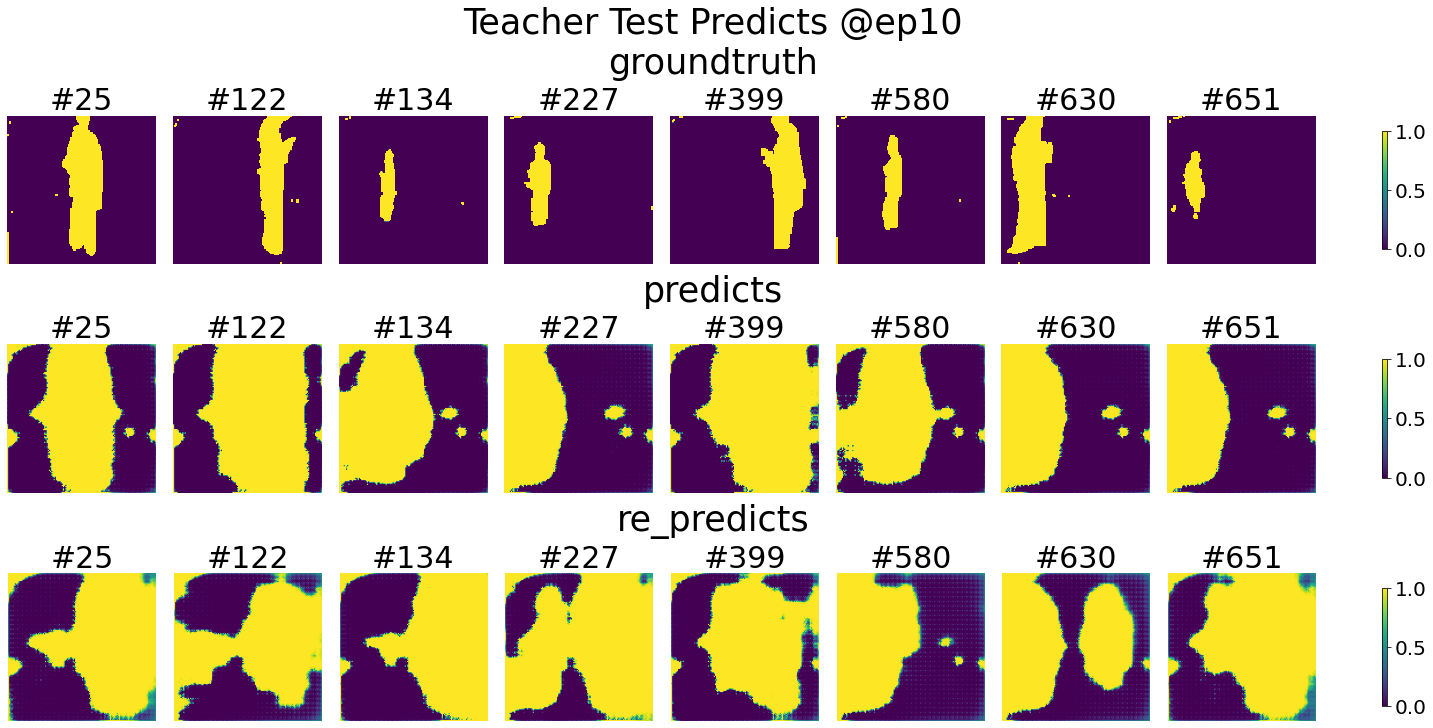

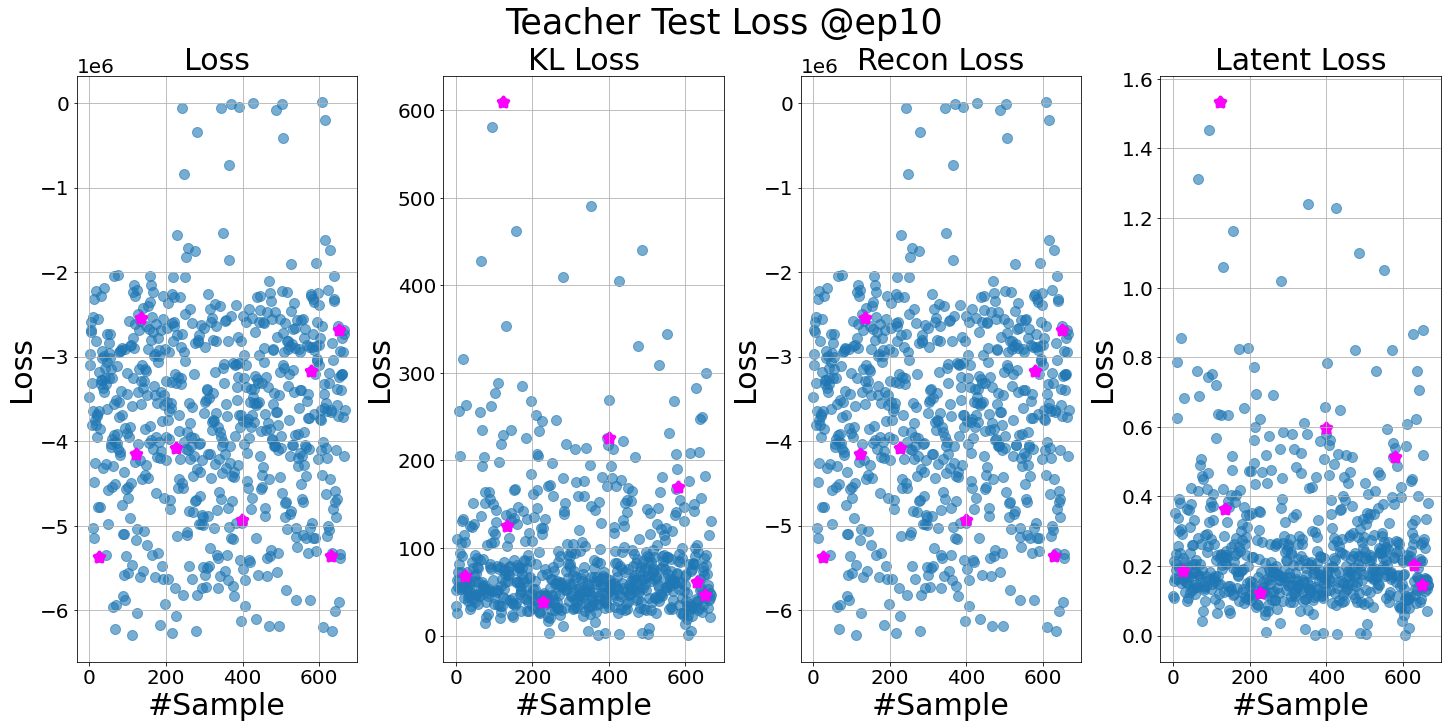

Teacher: epoch=9/10, 665/668 of train, recon_loss=-27355056.0, kl_loss=416.83325195312575
Total training time: 286.154972076416 sec
Teacher: 665/668 of test, loss=-2263745.75

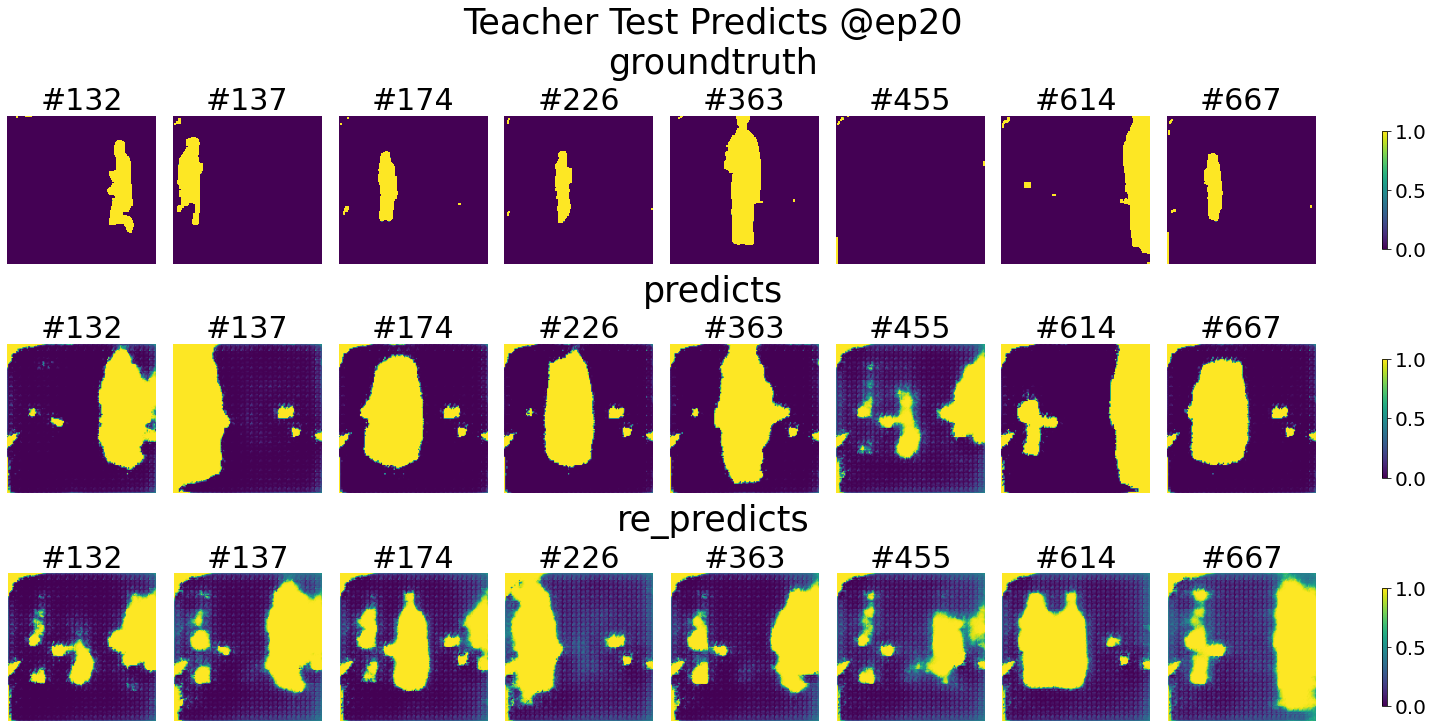

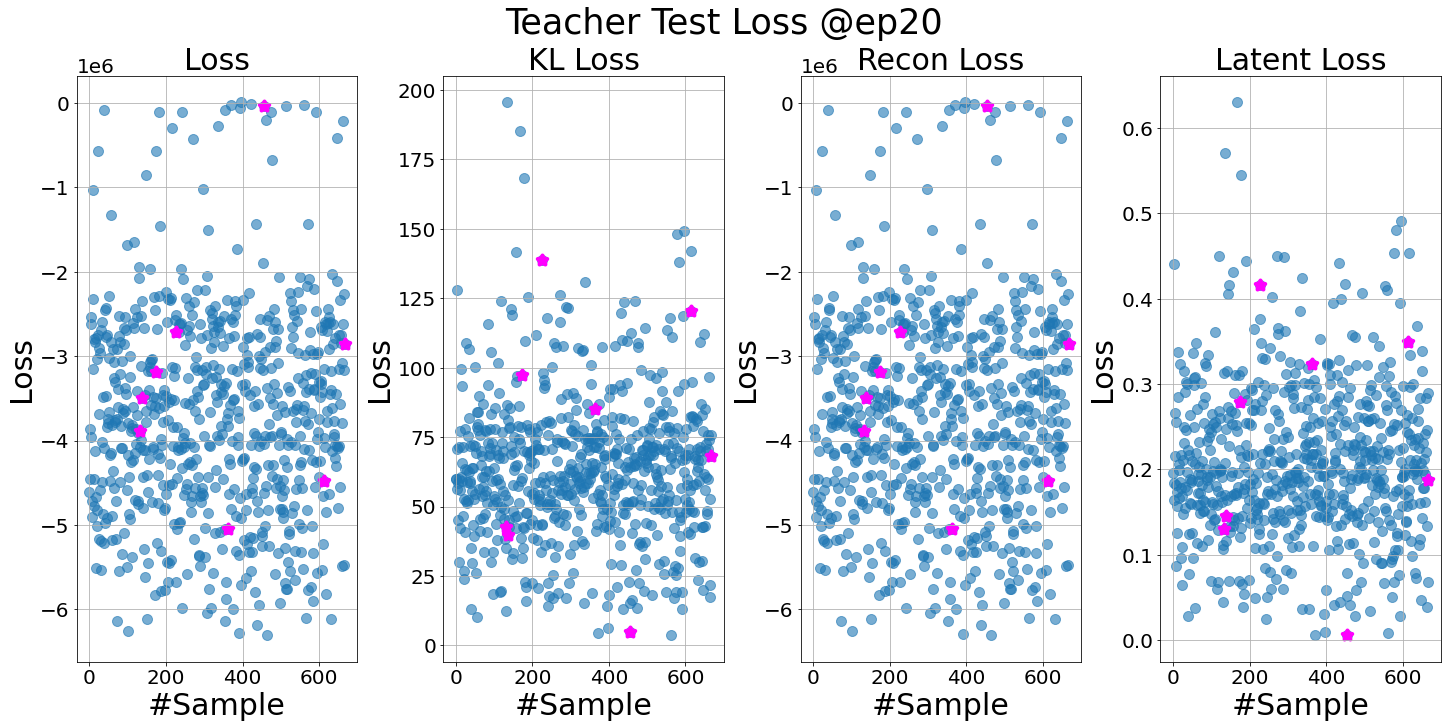

Teacher: epoch=9/10, 665/668 of train, recon_loss=-34402292.0, kl_loss=996.53601074218755
Total training time: 286.560914516449 sec
Teacher: 665/668 of test, loss=-4186449.55

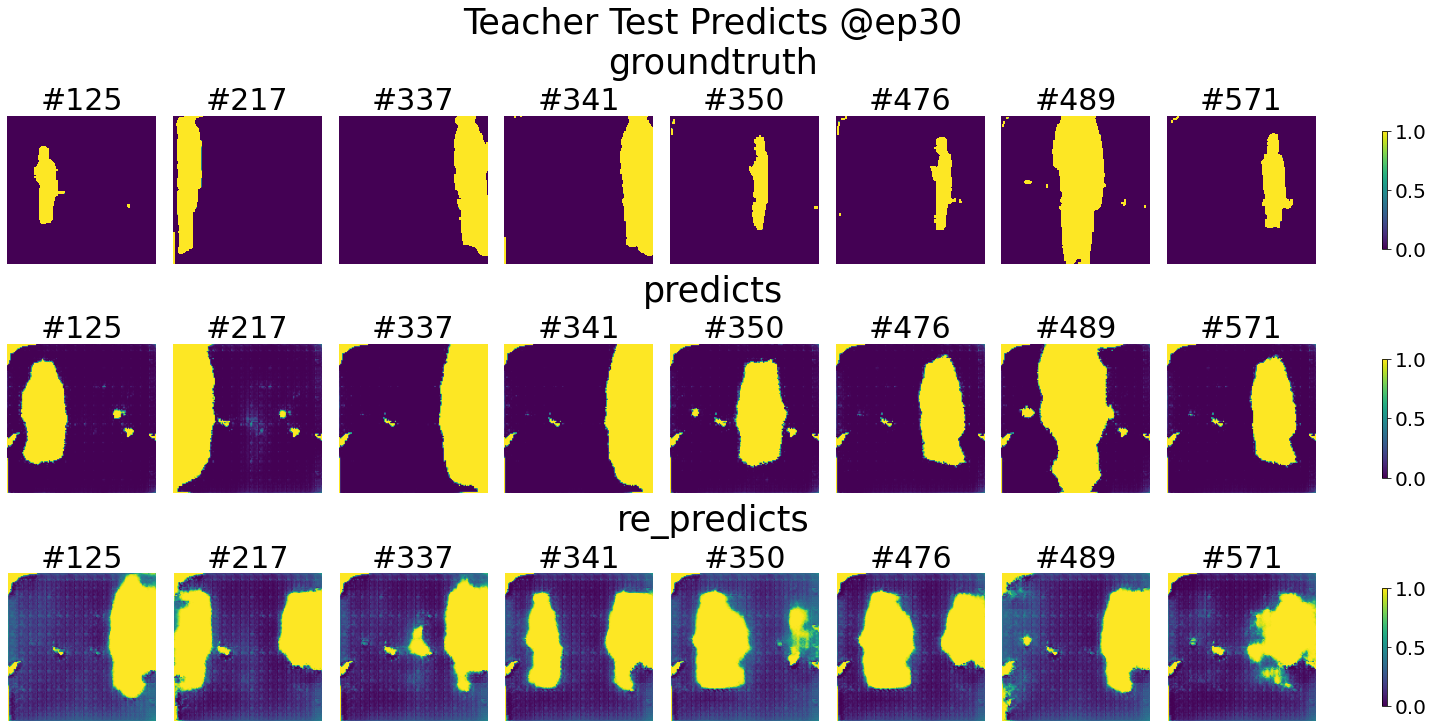

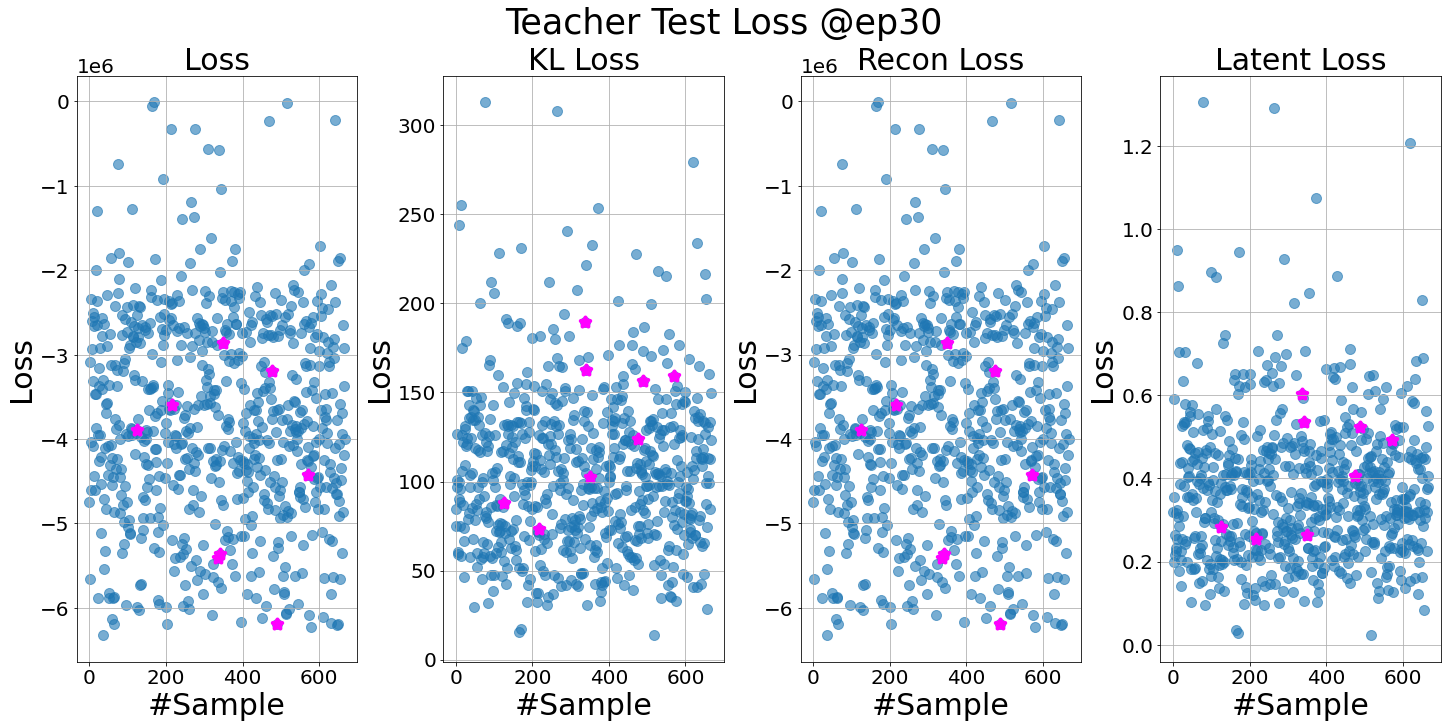

Teacher: epoch=9/10, 665/668 of train, recon_loss=-30424856.0, kl_loss=569.83325195312555
Total training time: 286.9802072048187 sec
Teacher: 665/668 of test, loss=-3013723.05

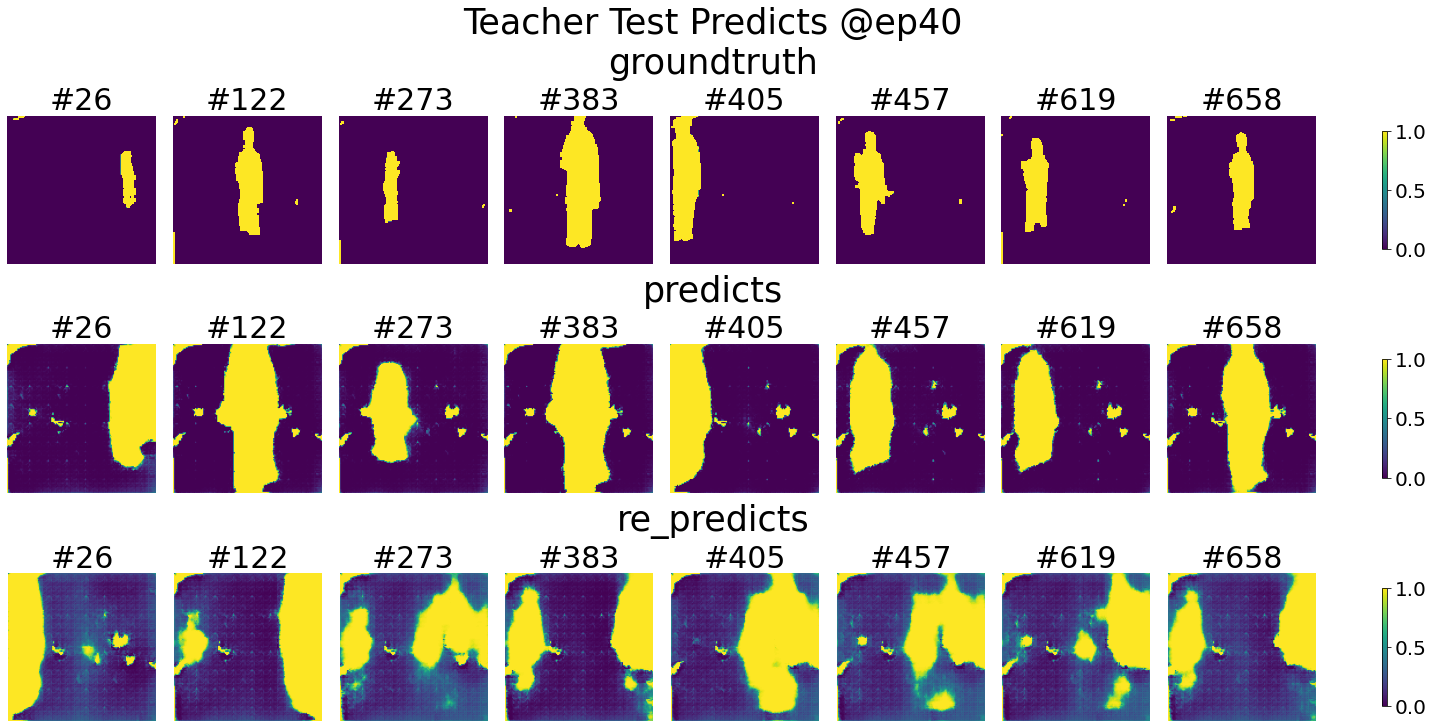

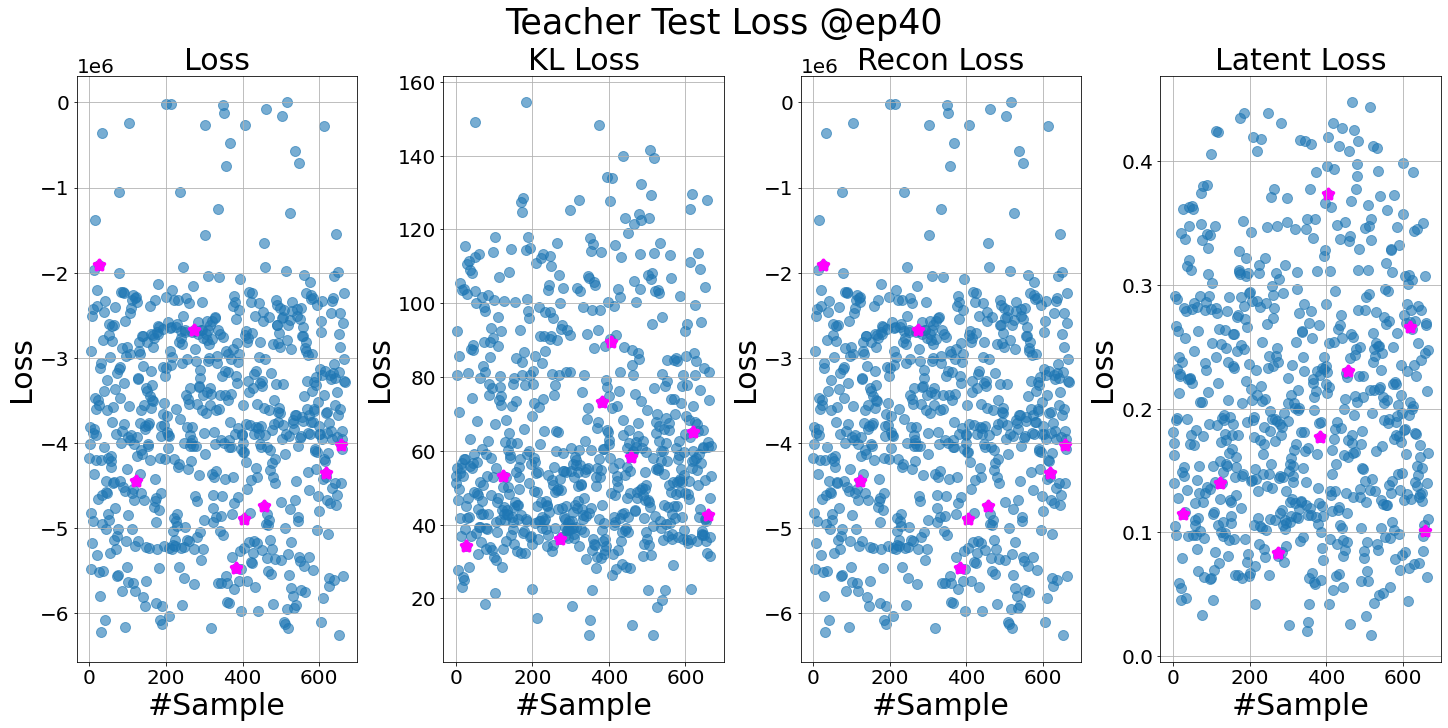

Teacher: epoch=9/10, 665/668 of train, recon_loss=-31291894.0, kl_loss=802.27941894531255
Total training time: 286.8433909416199 sec
Teacher: 665/668 of test, loss=-3978511.75

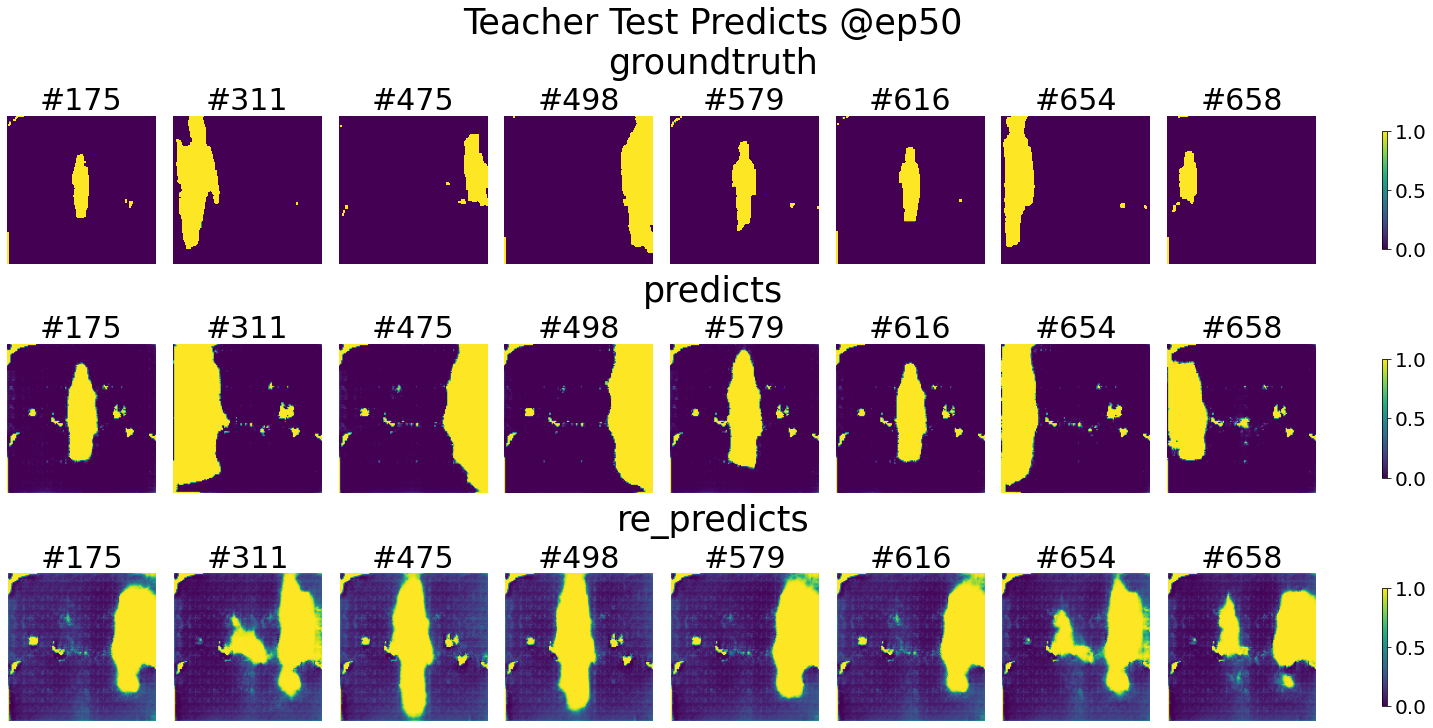

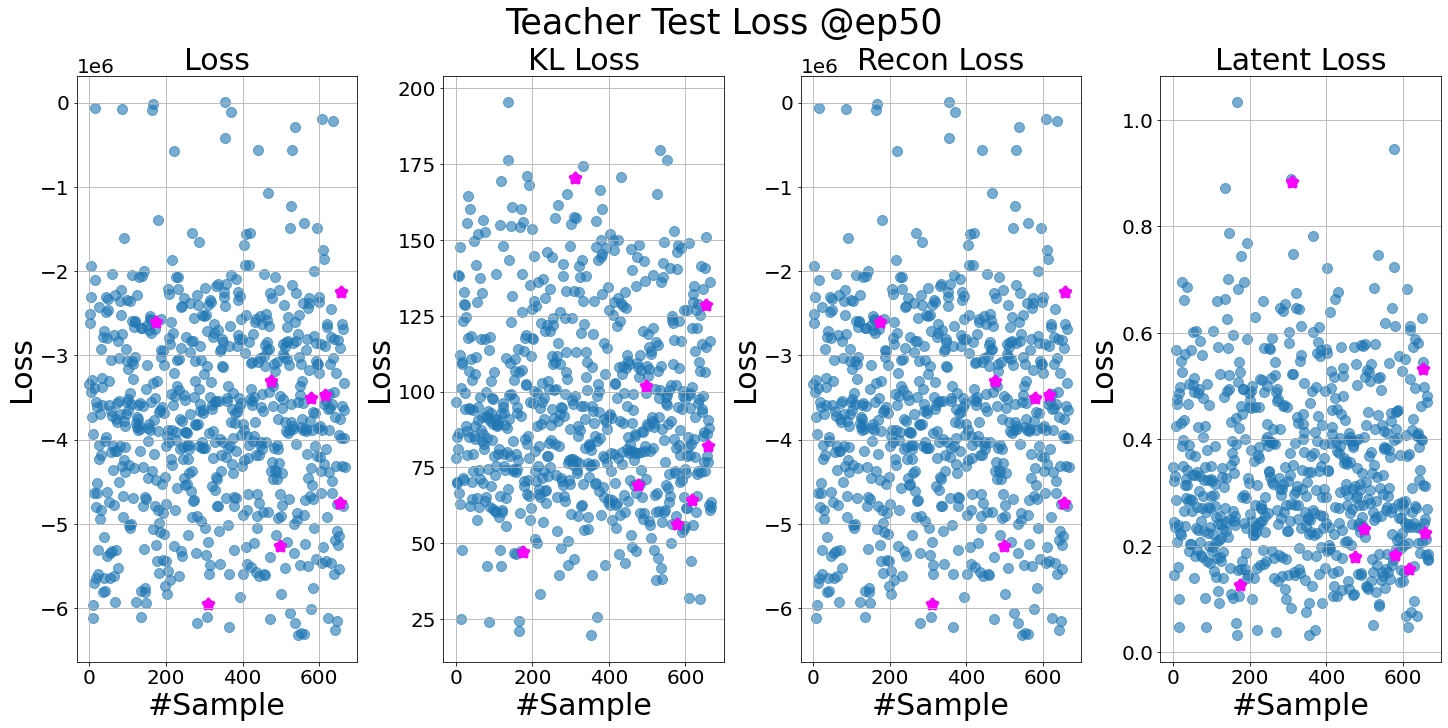

Teacher: epoch=4/10, 0/668 of train, recon_loss=-24861272.0, kl_loss=164956.8753593756255

/opt/conda/conda-bld/pytorch_1634272168290/work/aten/src/ATen/native/cuda/Loss.cu:115: operator(): block: [223,0,0], thread: [0,0,0] Assertion `input_val >= zero && input_val <= one` failed.
/opt/conda/conda-bld/pytorch_1634272168290/work/aten/src/ATen/native/cuda/Loss.cu:115: operator(): block: [223,0,0], thread: [1,0,0] Assertion `input_val >= zero && input_val <= one` failed.
/opt/conda/conda-bld/pytorch_1634272168290/work/aten/src/ATen/native/cuda/Loss.cu:115: operator(): block: [223,0,0], thread: [2,0,0] Assertion `input_val >= zero && input_val <= one` failed.
/opt/conda/conda-bld/pytorch_1634272168290/work/aten/src/ATen/native/cuda/Loss.cu:115: operator(): block: [223,0,0], thread: [3,0,0] Assertion `input_val >= zero && input_val <= one` failed.
/opt/conda/conda-bld/pytorch_1634272168290/work/aten/src/ATen/native/cuda/Loss.cu:115: operator(): block: [223,0,0], thread: [4,0,0] Assertion `input_val >= zero && input_val <= one` failed.
/opt/conda/conda-bld/pytorch_1634272168290/wo

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [6]:
# Scheduler
%matplotlib inline
turns = 10
notion = 'cycle_human_4'

for i in range(turns):
    trainer.train_teacher() 
    trainer.test_teacher(mode='train')
    trainer.plot_teacher_test(autosave=True, notion=notion)
trainer.plot_teacher_loss(autosave=True, notion=notion)

In [15]:
# Training and Saving
trainer.train_teacher()

Teacher: epoch=999/1000,2/3of train, loss=148.50308227539062
Total training time: 64.56917190551758 sec


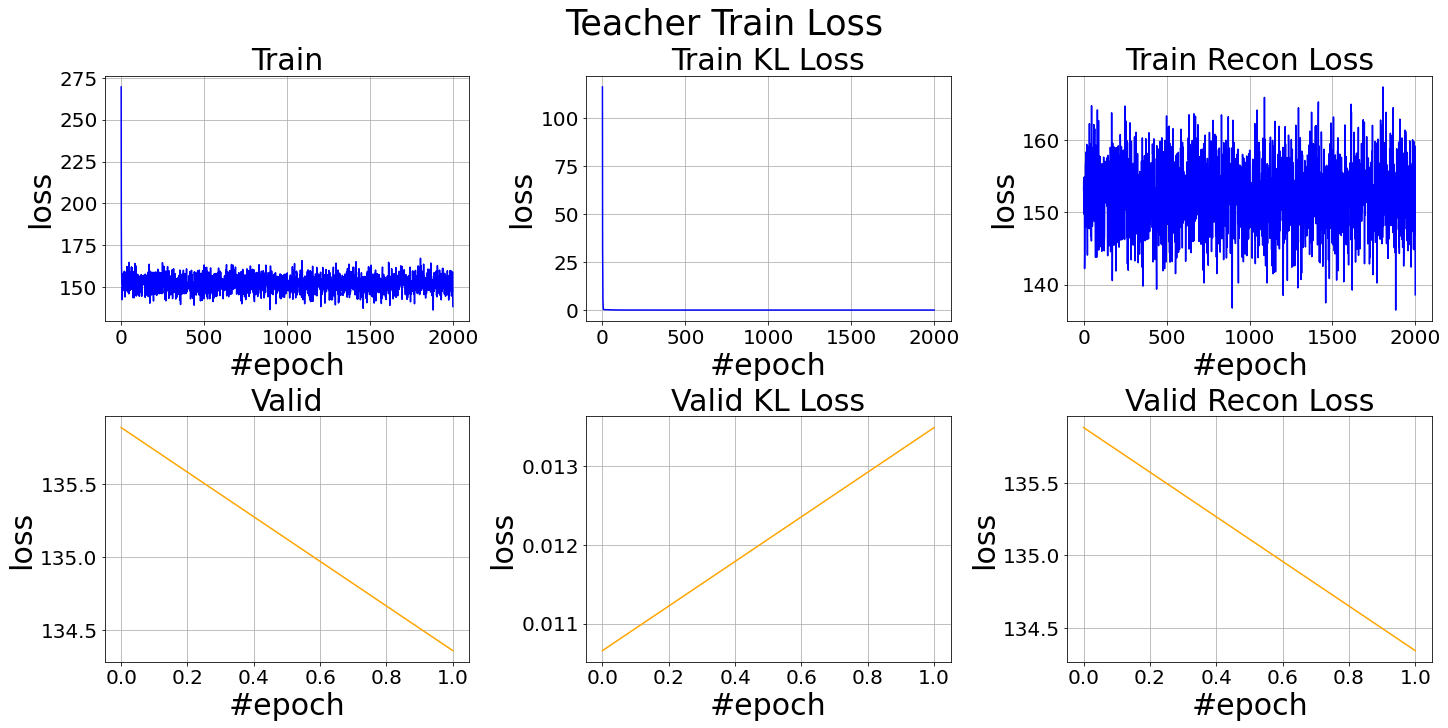

In [16]:
# Plot loss curves
%matplotlib inline
trainer.plot_teacher_loss()

In [17]:
  #=====================test============================
trainer.test_teacher(mode='train')

Teacher: 0/3of test, loss=237.51382446289062

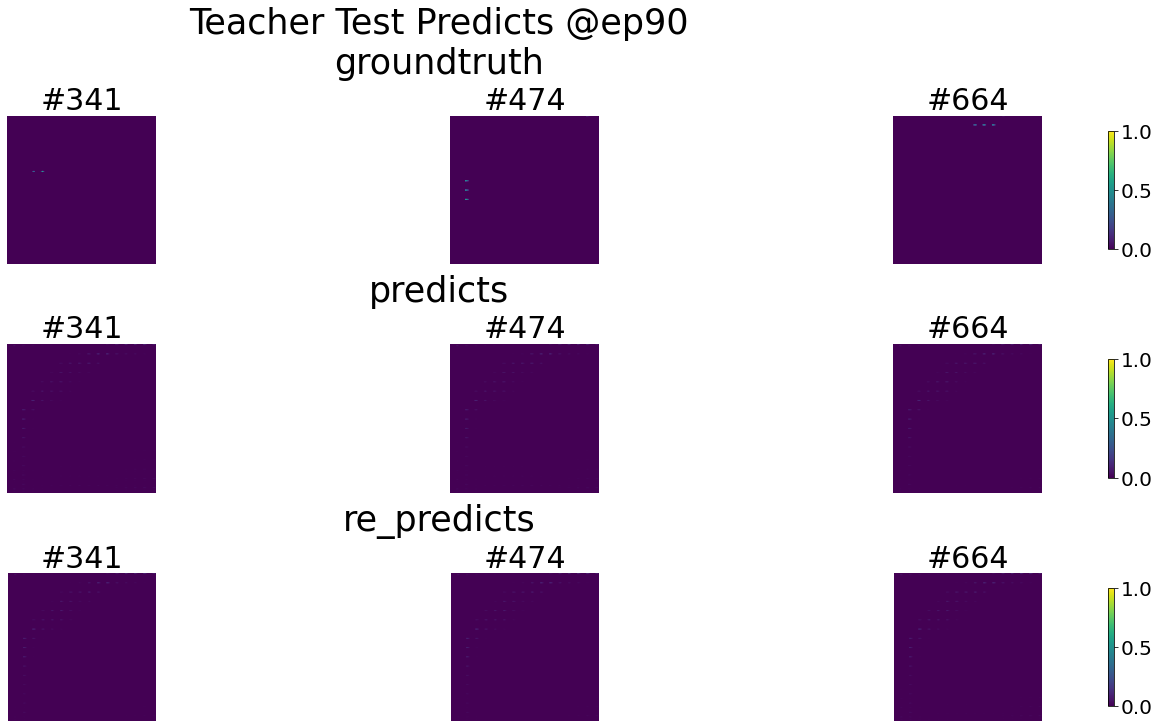

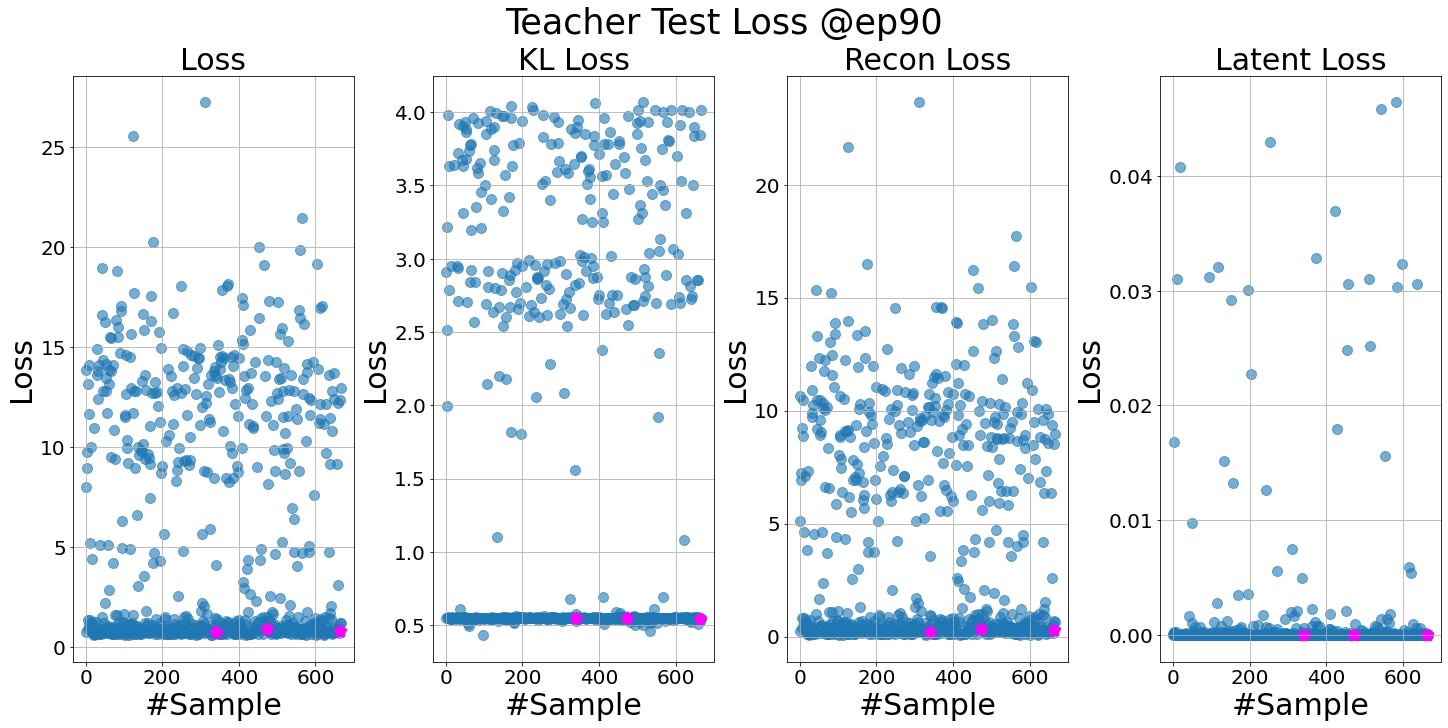

In [7]:
%matplotlib inline
trainer.plot_teacher_test(select_num=3)

# Training and Saving
trainer.train_student()

In [ ]:
# Plot loss curves
%matplotlib inline
trainer.plot_student_loss()

In [ ]:
  #=====================test============================
trainer.test_student()

In [ ]:
# Final outputs
%matplotlib inline
trainer.plot_student_test()

In [33]:
notion = '_0307'
torch.save(trainer.csi_encoder.state_dict(),
           '../Models/CSIEn_' + str(trainer.csi_encoder) + notion + '_tep' + str(trainer.teacher_epochs) +
           '_sep' + str(trainer.student_epochs) + '.pth')